In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 5)

# Simple two-marginal problem

In [3]:
n = 30
m = 30

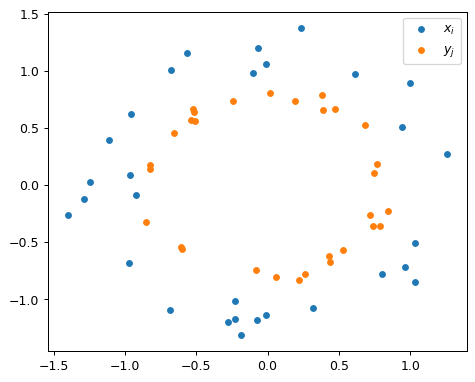

In [4]:
x = np.random.randn(n) * 1.5 * np.pi
x = 1.2 * np.stack([np.cos(x), np.sin(x)], axis=1) + 0.1 * np.random.randn(n, 2)

thet_y = np.random.randn(m) * 0.9 * np.pi
y = 0.8 * np.stack([np.cos(thet_y), np.sin(thet_y)], axis=1) + 0.05 * np.random.randn(m, 2) 

plt.scatter(*x.T, label="$x_i$", s=20)
plt.scatter(*y.T, label="$y_j$", s=20)
plt.legend()

The cost matrix is given by
\\[
    \mathbf{C}_{i,j} = |x_i - y_j|^2
\\]

Between the two datasets $X$ and $Y$, the Wasserstein distance is given by
$$
    \mathcal W_2^2(\mathbf a,\mathbf b) = \min_{\mathbf{P}: \mathbf P^T\mathbf 1 = \mathbf a,\;\mathbf P\mathbf 1 = \mathbf b}~\langle \mathbf P,\mathbf C\rangle
$$

Here, the mass assigned to each point is identical. The obvious solution is taking the nearest-neighbor mapping between the points of $X$ and $Y$.

The Kantorovitch dual problem is given by
$$
    \max_{(\mathbf f,\mathbf g)\in R(\mathbf C)}~ \langle \mathbf f,\mathbf a\rangle+\langle\mathbf g,\mathbf b\rangle
$$
where $R(\mathbf C) = \{ \mathbf f,\mathbf g : \mathbf 1\mathbf f^T + \mathbf g \mathbf 1^T \leq \mathbf C \}$

In [5]:
from scipy.spatial import distance

In [6]:
# the distance matrix
pairwise_dists = np.square(distance.cdist(x, y, metric='euclidean'))

## Sinkhorn

Define the Gibbs matrix
$$
    \mathbf K_{i,j} = \exp(-\mathbf C_{i,j}/\epsilon)
$$

$$
    \mathbf u^{(n+1)} = \frac{\mathbf a}{\mathbf K\mathbf v^{(n)}},
    \quad
    \mathbf v^{(n+1)} = \frac{\mathbf b}{\mathbf K^T\mathbf u^{(n+1)}}
$$

In [7]:
def sinkhorn(a, b, K, n_iters=10, verbose='last'):
    # Initialize
    v = np.ones_like(b) / b.size
    
    for i in range(n_iters):
        u_tmp = a / (K.dot(v))
        v_tmp = b / (np.dot(K.T, u_tmp))
        
        if (verbose=='last') and i+1==n_iters:
            du_norm = np.linalg.norm(u-u_tmp)
            dv_norm = np.linalg.norm(v-v_tmp)
            print("Rel. L2 improvement: u (%.3e); v (%.3e)"
                  % (du_norm/np.linalg.norm(u),
                     dv_norm/np.linalg.norm(v)))
        u = u_tmp
        v = v_tmp
    u = u[:, None]
    v = v[:, None]
    P = u * K * v.T
    err_u = np.linalg.norm(a - np.sum(P, axis=1), ord=1)
    err_v = np.linalg.norm(b - np.sum(P, axis=0), ord=1)
    print("Marginal constraint violation -- u: %.3e | v: %.3e"
          % (np.log(err_u), np.log(err_v)))
    return P, (u, v)

In [12]:
eps = 2e-3
cost_mat = pairwise_dists
K_mat = np.exp(-cost_mat / eps)

a_mes = np.ones(n) / n
b_mes = np.ones(m) / m

In [13]:
plan, (u, v) = sinkhorn(a_mes, b_mes, K_mat, n_iters=50)

Rel. L2 improvement: u (9.968e-01); v (6.288e-01)
Marginal constraint violation -- u: -1.088e+00 | v: -3.702e+01


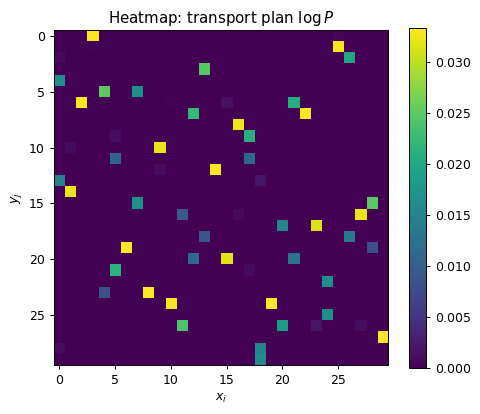

In [14]:
plt.imshow(plan, interpolation="nearest")
plt.xlabel("$x_i$")
plt.ylabel("$y_j$")
plt.title(r"Heatmap: transport plan $\log\,{P}$")
plt.colorbar()

Text(0.5, 1.0, 'Entropic OT plan $P$ (param. $\\epsilon=2.0e-03$)')

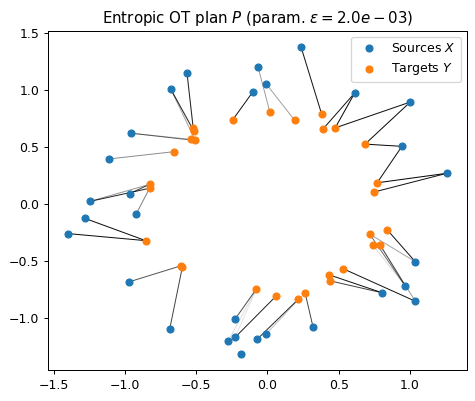

In [15]:
ot_max = plan.max()
threshold = 0.05 * ot_max

fig = plt.figure()

plt.scatter(*x.T, marker="o", s=30)
plt.scatter(*y.T, marker="o", s=30)

plt.legend(["Sources $X$", "Targets $Y$"])

for i in range(plan.shape[0]):
    for j in range(plan.shape[1]):
        if plan[i, j] > threshold:
            alph = plan[i, j] / threshold
            plt.plot([x[i,0], y[j, 0]], [x[i,1], y[j, 1]],
                     color='black', zorder=-1,
                     linewidth=0.8, alpha=alph)

plt.title("Entropic OT plan $P$ (param. $\epsilon=%.1e$)" % eps)

In [16]:
fig.savefig("/home/manifold/Pictures/transport_sinkhorn_test2.png")

# Towards multimarginal transport: three measure case

In [57]:
n = 20
m = 25
p = 15

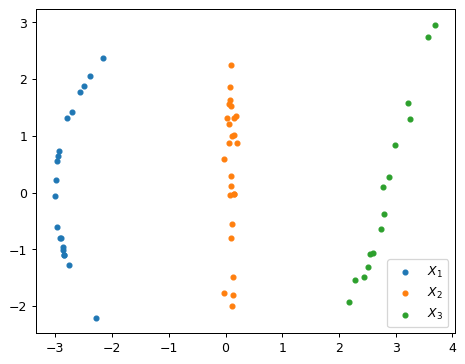

In [58]:
thet_x = (0.1 * np.random.randn(n) + 1.) * np.pi
x = np.array([0.8,0.]) + 3.8 * np.stack([np.cos(thet_x), np.sin(thet_x)],axis=1) +\
    0.01 * np.random.randn(n, 2)

y = np.stack([0.1 + 0.06 * np.random.randn(m),
              (2 * np.random.rand(m) - 1) * 2.5], axis=1)

rz = np.random.randn(p)
z = np.stack([2.8 + 0.1 * np.random.randn(p) + 0.4 * rz,
              1.5 * rz], axis=1)


plt.scatter(*x.T, s=15)
plt.scatter(*y.T, s=15)
plt.scatter(*z.T, s=15)
plt.legend(["$X_1$", "$X_2$", "$X_3$"])
ax = plt.gca()
ax.set_aspect("equal")

We want to perform transport between three measures $\boldsymbol \mu_i$, $i=1,2,3$.

Given a cost matrix $\mathbf C = (\mathbf C_{i,j,k})$, we want to find $\mathbf P \in \mathbb R^{n_1\times n_2\times n_3}$ solving
$$
    \min_{\mathbf P}~ \langle \mathbf P, \mathbf C\rangle
$$
under the constraint that the sum of $\mathbf P$ along its axes $(0,2)$ is $\boldsymbol \mu_1$, etc.

Here the dot product is defined intuitively as
$$
    \langle\mathbf P,\mathbf C\rangle =
    \sum_{k=1}^3 \sum_{i_k = 1}^{n_k}
    \mathbf P_{i_1,i_2,i_3} \mathbf C_{i_1,i_2,i_3}
$$

For our first application we will use the total Euclidean distance from left-to-right
$$
    \mathbf C_{i,j,k} = |x_{1,i} - x_{2,j}|^2 + |x_{2,j} - x_{3,k}|^2 +
    \kappa|x_{1,i} - x_{3,k}|^2
$$
where $\kappa$ is big so as to penalize transport that skips the middle dataset.

In [59]:
cost_mat = np.zeros((n, m, p))
print("Full cost matrix shape:", cost_mat.shape)

cost_mat1 = np.expand_dims(distance.cdist(x, y), 2) ** 2
print("1:", cost_mat1.shape)
cost_mat2 = np.expand_dims(distance.cdist(y, z), 0) ** 2
print("2:", cost_mat2.shape)
cost_mat3 = np.expand_dims(distance.cdist(x, z), 1) ** 2
print("3:", cost_mat3.shape)

Full cost matrix shape: (20, 25, 15)
1: (20, 25, 1)
2: (1, 25, 15)
3: (20, 1, 15)


In [60]:
cost_mat[:] = cost_mat1 + cost_mat2

In [61]:
mu1, mu2, mu3 = [np.ones(s)/s for s in [n, m, p]]

The adapted Sinkhorn algorithm reads
$$
    \mathbf u_{j, i_j} \leftarrow
    \frac{
        \boldsymbol \mu_{j,i_j}
    }{
        \sum_{k\neq j} \sum_{i_k}^{n_k} \mathbf K_{i_1,\ldots,i_3}\prod_{r\neq j}\mathbf u_{r,i_r}
    }
$$

or
$$
    \mathbf u_{j,i_j} \leftarrow
    \frac{
        \boldsymbol \mu_j
    }{
        \mathbf K^{j,i_j} [\mathbf u_r]_{r\neq j}
    }
$$
where $\mathbf K^{j,i_j}$ is the $2$-tensor (a bilinear map) obtained by keeping slice $i_j$ along the $j$-th axis of $\mathbf K$.

In [111]:
class ThreeMargSinkhorn:
    r"""
    Sinkhorn algorithm for transport between three measures
    `mu_1`, `mu_2` and `mu_3`.
    """
    def __init__(self, mu1, mu2, mu3, cost: np.ndarray, eps=1e-1):
        self.mu1 = mu1
        self.mu2 = mu2
        self.mu3 = mu3
        self.cost = cost
        self.eps = eps
        # Make the Gibbs matrix
        self.K: np.ndarray = np.exp(-self.cost / eps)
        print("Gibbs matrix shape:", self.K.shape)
    
    def compute(self, n_iter=20):
        u3 = np.ones_like(self.mu3) / self.mu3.size
        mus = [mu1, mu2, mu3]
        
        for n in range(n_iter):
            den = []
            for s in range(3):
                u_prod = np.outer(mus[s+1], mus[(s+2) % 3])
                K_a = self.K.swapaxes(0, s)
                print("uprod shape:", u_prod.shape)
                print("K_a shape:", K_a.shape)
                den.append(
                    np.tensordot(K_a, u_prod)
                )
            for d in den: print(d.shape)
            u1 = self.mu1 / den


In [112]:
sink = ThreeMargSinkhorn(mu1, mu2, mu3, cost_mat)

Gibbs matrix shape: (20, 25, 15)


In [113]:
sink.K.shape

(20, 25, 15)

In [114]:
sink.K.swapaxes(0, 1).shape

(25, 20, 15)

In [115]:
sink.K.swapaxes(0, 2).shape

(15, 25, 20)

In [116]:
sink.compute()

uprod shape: (25, 15)
K_a shape: (20, 25, 15)
uprod shape: (15, 20)
K_a shape: (25, 20, 15)


ValueError: shape-mismatch for sum

In [47]:
np.tensordot(sink.K, np.outer(sink.mu2, sink.mu3)).shape

(25,)

In [28]:
sink.K.shape

(25, 25, 15)